In [47]:
from __future__ import division

import os
import operator
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle

from utils import *
from skimage import transform 
from tqdm import tqdm, tqdm_notebook
from keras import initializers
from keras.layers import Input
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam

# share GPU
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.49
set_session(tf.Session(config=config))

%matplotlib inline

In [48]:
# data constants
max_size = (32, 32, 1)
data_files = {'cifar': '../data/cifar.npy',
              'mnist': '../data/mnist.npy',
              'lfw': '../data/lfw.npy'}

# load and transform data
data = np.load(data_files['mnist'])
data = data.astype('float32')

if data.shape[1:3] > max_size:
    data = np.array([transform.resize(image, max_size, preserve_range=True, order=0)] 
                    for image in data)

# shuffle data
np.random.shuffle(data)

# get data sizes
data_count = data.shape[0]
data_size = data.shape[1:4] if data.shape[3] > 1 else data.shape[1:3]
data_dim = reduce(operator.mul, data.shape[1:])

# reshape data if necessary
data = data.reshape(data_count, *data_size)

print 'Loaded data {}'.format(data.shape)

Loaded data (70000, 28, 28)


In [49]:
data_reshaped = data.reshape(data_count, -1)
data_mean = np.mean(data_reshaped, axis=1, keepdims=True, dtype=np.float64)
data_z_mean = (data_reshaped - data_mean)
data_std = np.std(data_z_mean, axis=1, keepdims=True, dtype=np.float64) + 1e-16
data_normed = data_z_mean / data_std
data_proc = data_normed.reshape(data_count, *data_size)

print 'Before preproc', data.mean(), data.std()
print 'After preproc', data_proc.mean(), data_proc.std()

Before preproc 33.386 78.6544
After preproc 1.04872379002e-19 1.0


In [50]:
# latent space generators
def get_uniform_space(high, low, space_size):
    return lambda batch_size: np.random.uniform(low, high, (batch_size, space_size)).astype('float32')

def get_gaussian_space(mean, var, space_size):
    return lambda batch_size: np.random.normal(mean, var, (batch_size, space_size)).astype('float32')

In [54]:
def get_mlp_model(data_dim, latent_dim):
    # setup optimizer
    opt = Adam(lr=0.0002, beta_1=0.5)

    leaky_alpha = 0.0
    dropout_p = 0.3
    # setup generator network
    generator = Sequential()
    generator.add(Dense(256, input_dim=latent_dim, kernel_initializer='random_normal'))
    generator.add(LeakyReLU(alpha=leaky_alpha))
    generator.add(Dense(512))
    generator.add(LeakyReLU(alpha=leaky_alpha))
    generator.add(Dense(1024))
    generator.add(LeakyReLU(alpha=leaky_alpha))
    generator.add(Dense(data_dim, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=opt)

    # setup discriminator network
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=data_dim, kernel_initializer='random_normal'))
    discriminator.add(LeakyReLU(alpha=leaky_alpha))
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(alpha=leaky_alpha))
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(alpha=leaky_alpha))
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=opt)

    # setup combined network
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    gan_output = discriminator(generator(gan_input))
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=opt)
    return (generator, discriminator, gan)

100%|██████████| 546/546 [00:25<00:00, 21.73it/s]


epoch: 0 -- loss G: 1.47737085819 - D: 0.379453778267


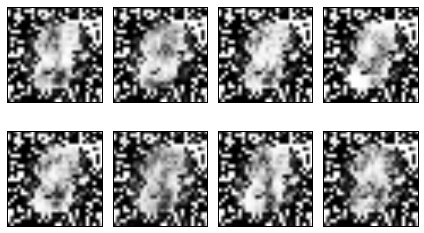

100%|██████████| 546/546 [00:21<00:00, 26.03it/s]


epoch: 1 -- loss G: 2.54071497917 - D: 0.251119822264


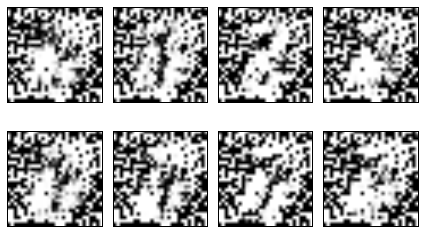

 93%|█████████▎| 510/546 [00:19<00:01, 26.15it/s]

In [ ]:
# setup experiment
max_epochs = 50
batch_size = 128
latent_dim = 100
z_space = get_gaussian_space(0, 1, latent_dim)
generator, discriminator, gen_dis = get_mlp_model(data_dim, latent_dim)

# prepare data
dis_labels = np.ones(2*batch_size) * 0.9# np.random.uniform(0.85, 1.0, 2*batch_size)
dis_labels[:batch_size] = 0 
gan_labels = np.ones(batch_size)

g_losses = []
d_losses = []

for epoch_ix in xrange(max_epochs):
    for batch_ix in tqdm(xrange(0, data_count-batch_size, batch_size)):
        # train discriminator - true
        discriminator.trainable = True
        x_samples = data_proc[batch_ix: batch_ix+batch_size].reshape(batch_size, -1)
        d_loss_t = discriminator.train_on_batch(
            x_samples, dis_labels[batch_size:])
        
        # train discriminator - fake
        z_samples = z_space(batch_size).astype('float32')
        d_loss_f = discriminator.train_on_batch(
            np.vstack(generator.predict(z_samples)), dis_labels[:batch_size])
        
        d_loss = (d_loss_t + d_loss_f) / 2

        # train generator
        z_samples = z_space(batch_size).astype('float32')
        discriminator.trainable = False
        g_loss = gen_dis.train_on_batch(z_samples, gan_labels)

    g_losses.append(g_loss)
    d_losses.append(d_loss)
    
    print 'epoch: {} -- loss G: {} - D: {}'.format(epoch_ix, 
                                                   g_loss, 
                                                   d_loss)
    z_samples = z_space(batch_size).astype('float32')
    fakes = generator.predict(z_samples[:8,:])
    plot_images(fakes, data_size)

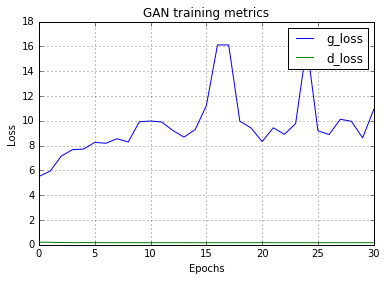

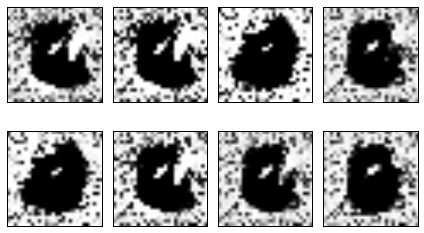

In [37]:
plot_performance(('g_loss', g_losses), ('d_loss', d_losses))

z_samples = z_space(batch_size).astype('float32')
fakes = generator.predict(z_samples[:8,:])
plot_images(fakes, data_size, to_file=True)